# Notebook 06: Model Gallery — Linear vs. Tapered Comparison

**Objective:** Compare the Flynn (2025) Linear Model and the Schneider (2026)
Tapered Model across a diverse sample of galaxies. Test whether the galaxy's
Central Surface Brightness ($\Sigma_0$) can predict which model is preferred,
as suggested by the Phase II population split (Notebook 05).

## Models

| Model | Formula | Parameters | Label |
|-------|---------|------------|-------|
| **Flynn 2025 (Linear)** | $V_{\text{model}} = V_{\text{bary}} + \omega R$ | $\omega$ (1 param) | Boundary Solution |
| **Schneider 2026 (Tapered)** | $V_{\text{model}} = V_{\text{bary}} + \frac{\omega R}{1 + R/R_t}$ | $\omega, R_t$ (2 params) | Interior Solution |

## Prediction Logic

Using the $\Sigma_0$ thresholds observed in Phase II:
- **$\Sigma_0 < 300$** $L_\odot/\text{pc}^2$: Predict **Tapered** (LSB regime)
- **$\Sigma_0 > 700$** $L_\odot/\text{pc}^2$: Predict **Linear** (HSB regime)
- **$300 \leq \Sigma_0 \leq 700$**: **Transition Zone** (no prediction)

The verification table at the end scores how often the prediction matches
the BIC-preferred model.

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from pathlib import Path

from src.physics import (
    compute_v_bary,
    fit_omega,
    fit_omega_tapered,
    compute_bic,
)
from src.ingest import parse_sparc_metadata_mrt
from src.database import get_engine, get_session, query_profiles_as_dataframe
from src.utils import setup_logger, get_project_root

sns.set_theme(style='whitegrid', font_scale=1.1)
%matplotlib inline

# Constants (consistent with Notebooks 01–05)
UPSILON_DISK = 0.5
UPSILON_BULGE = 0.7

# Paths
PROJECT_ROOT = get_project_root()
RESULTS_DIR = PROJECT_ROOT / 'results'
TABLES_DIR = RESULTS_DIR / 'tables'
FIGURES_DIR = RESULTS_DIR / 'figures'
TABLES_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f'Project root: {PROJECT_ROOT}')

Project root: C:\Projects\ISM\baryonic-omega-analysis


## 1. Robust Tapered Fit (Monkey-Patch)

HSB galaxies can push $R_t \to \infty$, causing the standard `fit_omega_tapered`
to struggle with optimizer convergence. This wrapper uses adaptive initial
guesses and wider bounds to handle both LSB and HSB galaxies reliably.

In [2]:
from src.physics import TaperedFitResult


def fit_omega_tapered_robust(
    radius, v_obs, v_err, v_bary,
    galaxy_id='unknown',
    method_version='v3_gallery_robust',
    upsilon_disk=0.5,
    upsilon_bulge=0.7,
):
    """Robust tapered fit that handles both LSB and HSB galaxies.

    For HSB galaxies where R_t -> large, the standard fit can fail.
    This version tries multiple initial guesses and uses wider R_t bounds.
    """
    radius = np.asarray(radius, dtype=np.float64)
    v_obs = np.asarray(v_obs, dtype=np.float64)
    v_err = np.asarray(v_err, dtype=np.float64)
    v_bary = np.asarray(v_bary, dtype=np.float64)

    n_points = len(radius)
    positive_errs = v_err[v_err > 0]
    min_err = float(np.min(positive_errs)) if len(positive_errs) > 0 else 1.0
    v_err_safe = np.where(v_err > 0, v_err, min_err)
    flag_v_obs_lt_v_bary = bool(np.any(v_obs < v_bary))

    def _model(r, omega, r_t):
        return v_bary + omega * r / (1.0 + r / r_t)

    r_max = radius.max()

    # Try multiple initial guesses: small R_t (LSB), medium, large (HSB)
    initial_guesses = [
        [5.0, r_max * 0.3],
        [10.0, r_max * 0.1],
        [3.0, r_max * 1.0],
        [20.0, r_max * 2.0],
    ]

    omega_bounds = (0.0, 200.0)
    rt_bounds = (0.1, r_max * 5.0)

    best_result = None
    best_chi2 = np.inf

    for p0 in initial_guesses:
        p0_clipped = [
            np.clip(p0[0], omega_bounds[0] + 0.01, omega_bounds[1] - 0.01),
            np.clip(p0[1], rt_bounds[0] + 0.01, rt_bounds[1] - 0.01),
        ]
        try:
            popt, pcov = curve_fit(
                _model, radius, v_obs,
                p0=p0_clipped,
                sigma=v_err_safe, absolute_sigma=True,
                bounds=([omega_bounds[0], rt_bounds[0]],
                        [omega_bounds[1], rt_bounds[1]]),
                maxfev=10000,
            )
            v_model_try = _model(radius, *popt)
            residuals_try = v_obs - v_model_try
            chi2_try = float(np.sum((residuals_try / v_err_safe) ** 2))

            if chi2_try < best_chi2:
                best_chi2 = chi2_try
                best_result = (popt, pcov, v_model_try, residuals_try, chi2_try)
        except RuntimeError:
            continue

    if best_result is None:
        # All attempts failed — return unconverged result
        nan = float('nan')
        v_model = _model(radius, 0.0, 1.0)
        return TaperedFitResult(
            galaxy_id=galaxy_id, model_name='rational_taper_robust',
            omega_value=nan, omega_uncertainty=nan,
            rt_value=nan, rt_uncertainty=nan,
            chi_squared=nan, reduced_chi_squared=nan,
            residuals_rmse=nan, n_points=n_points, n_params=2,
            converged=False, flag_v_obs_lt_v_bary=flag_v_obs_lt_v_bary,
            method_version=method_version,
            upsilon_disk=upsilon_disk, upsilon_bulge=upsilon_bulge,
            v_bary=v_bary, v_model=v_model, residuals=v_obs - v_model,
        )

    popt, pcov, v_model, residuals, chi2 = best_result
    omega_best, rt_best = float(popt[0]), float(popt[1])
    perr = np.sqrt(np.diag(pcov))
    dof = max(n_points - 2, 1)
    reduced_chi2 = chi2 / dof
    rmse = float(np.sqrt(np.mean(residuals**2)))

    return TaperedFitResult(
        galaxy_id=galaxy_id, model_name='rational_taper_robust',
        omega_value=omega_best, omega_uncertainty=float(perr[0]),
        rt_value=rt_best, rt_uncertainty=float(perr[1]),
        chi_squared=chi2, reduced_chi_squared=reduced_chi2,
        residuals_rmse=rmse, n_points=n_points, n_params=2,
        converged=True, flag_v_obs_lt_v_bary=flag_v_obs_lt_v_bary,
        method_version=method_version,
        upsilon_disk=upsilon_disk, upsilon_bulge=upsilon_bulge,
        v_bary=v_bary, v_model=v_model, residuals=residuals,
    )


print('Robust tapered fitter defined.')

Robust tapered fitter defined.


## 2. The Predictor Function

Classify galaxies into regimes based on Central Surface Brightness.
Thresholds are drawn from the Phase II population medians (Notebook 05).

In [3]:
def predict_regime(galaxy_id, luminosity, r_disk):
    """Predict whether a galaxy is in the Linear or Tapered regime.

    Args:
        galaxy_id: Galaxy identifier.
        luminosity: Total luminosity in 10^9 Lsun.
        r_disk: Disk scale length in kpc.

    Returns:
        Tuple of (sigma_0, prediction_label, expected_k_range).
    """
    # Central surface brightness: Sigma_0 [Lsun/pc^2]
    # L is in 10^9 Lsun, R_d in kpc
    # Sigma_0 = (L * 1e9) / (2 * pi * R_d^2) * 1e-6
    # where 1e-6 converts from Lsun/kpc^2 to Lsun/pc^2
    sigma_0 = (luminosity * 1e9) / (2 * np.pi * r_disk**2) * 1e-6

    if sigma_0 < 300:
        prediction = 'Tapered (LSB Regime)'
        k_range = 'k ~ 2-5'
    elif sigma_0 > 700:
        prediction = 'Linear (HSB Regime)'
        k_range = 'k -> inf'
    else:
        prediction = 'Transition Zone'
        k_range = 'k ~ 5-15'

    return sigma_0, prediction, k_range


# Quick test
print('Predictor test:')
for test_name, test_L, test_Rd in [('LSB_test', 0.05, 2.0), ('HSB_test', 50.0, 3.0)]:
    s0, pred, kr = predict_regime(test_name, test_L, test_Rd)
    print(f'  {test_name}: Sigma_0 = {s0:.1f} Lsun/pc^2 -> {pred} ({kr})')

Predictor test:
  LSB_test: Sigma_0 = 2.0 Lsun/pc^2 -> Tapered (LSB Regime) (k ~ 2-5)
  HSB_test: Sigma_0 = 884.2 Lsun/pc^2 -> Linear (HSB Regime) (k -> inf)


## 3. Galaxy Selection & Metadata

In [ ]:
# Parse SPARC metadata
metadata_path = PROJECT_ROOT / 'data' / 'raw' / 'SPARC_Lelli2016c.mrt'
meta_df = parse_sparc_metadata_mrt(metadata_path)
meta_lookup = meta_df.set_index('galaxy_id')

# Gallery selection: diverse sample spanning the full Sigma_0 range
GALLERY_GALAXIES = [
    'DDO154',    # LSB dwarf
    'NGC3198',   # Intermediate spiral
    'DDO161',    # Dwarf irregular
    'NGC2841',   # HSB massive spiral
    'NGC7331',   # HSB spiral
    'NGC0300',   # Nearby Sc, M33-like
    'M33',       # Calibration target
]

# Verify all are in the database
engine = get_engine()
session = get_session(engine)

available = []
for gid in GALLERY_GALAXIES:
    df = query_profiles_as_dataframe(session, gid)
    if df.empty:
        print(f'  WARNING: {gid} not found in database — skipping.')
    else:
        available.append(gid)
        # Get metadata
        if gid in meta_lookup.index:
            lum = float(meta_lookup.loc[gid, 'luminosity_band_36'])
            r_d = float(meta_lookup.loc[gid, 'r_disk_kpc'])
            s0, pred, kr = predict_regime(gid, lum, r_d)
            print(f'  {gid:12s}: N={len(df):3d} pts, L={lum:.3f} (10^9 Lsun), '
                  f'R_d={r_d:.2f} kpc, Sigma_0={s0:.1f} Lsun/pc^2 -> {pred}')
        else:
            print(f'  {gid:12s}: N={len(df):3d} pts (no SPARC metadata)')

print(f'\nGallery: {len(available)} galaxies ready.')

## 4. The Comparison Loop (Core)

For each galaxy:
1. Fetch data from the database
2. Run **Fit A** (Flynn 2025 Linear): $V_{\text{boost}} = \omega R$
3. Run **Fit B** (Schneider 2026 Tapered): $V_{\text{boost}} = \frac{\omega R}{1 + R/R_t}$
4. Compute RMSE and BIC for both
5. Generate 2-panel plots (Rotation Curve + Residuals)

2026-02-15 07:57:47 | INFO     | src.physics | DDO154: omega=7.2104 +/- 0.0274 km/s/kpc  chi2_r=85.87  RMSE=5.46 km/s



Processing: DDO154
  Sigma_0 = 61.6 Lsun/pc^2
  Prediction: Tapered (LSB Regime)
  Linear:  omega=7.210, RMSE=5.46, BIC=947.0
  Tapered: omega=15.525, R_t=3.25, RMSE=1.51, BIC=38.8
  Delta BIC = 908.2 -> Preferred: Tapered
  Verdict: CORRECT


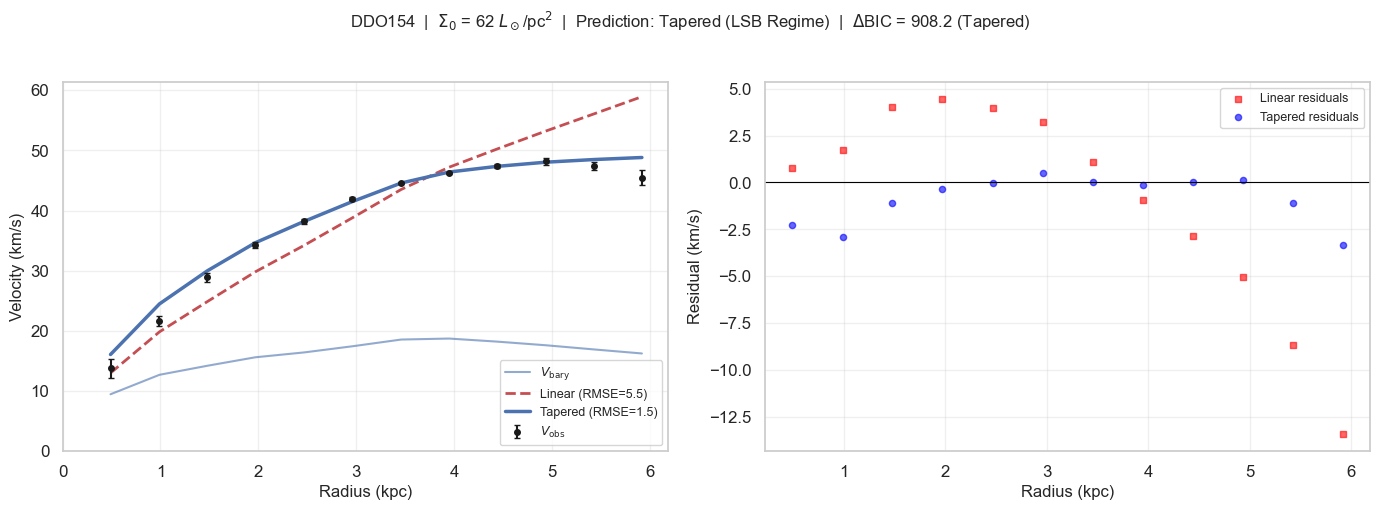

2026-02-15 07:57:47 | INFO     | src.physics | NGC3198: omega=2.8301 +/- 0.0169 km/s/kpc  chi2_r=113.07  RMSE=22.34 km/s



Processing: NGC3198
  Sigma_0 = 617.9 Lsun/pc^2
  Prediction: Transition Zone
  Linear:  omega=2.830, RMSE=22.34, BIC=4752.7
  Tapered: omega=11.790, R_t=8.66, RMSE=6.44, BIC=63.4
  Delta BIC = 4689.3 -> Preferred: Tapered
  Verdict: N/A (Transition)


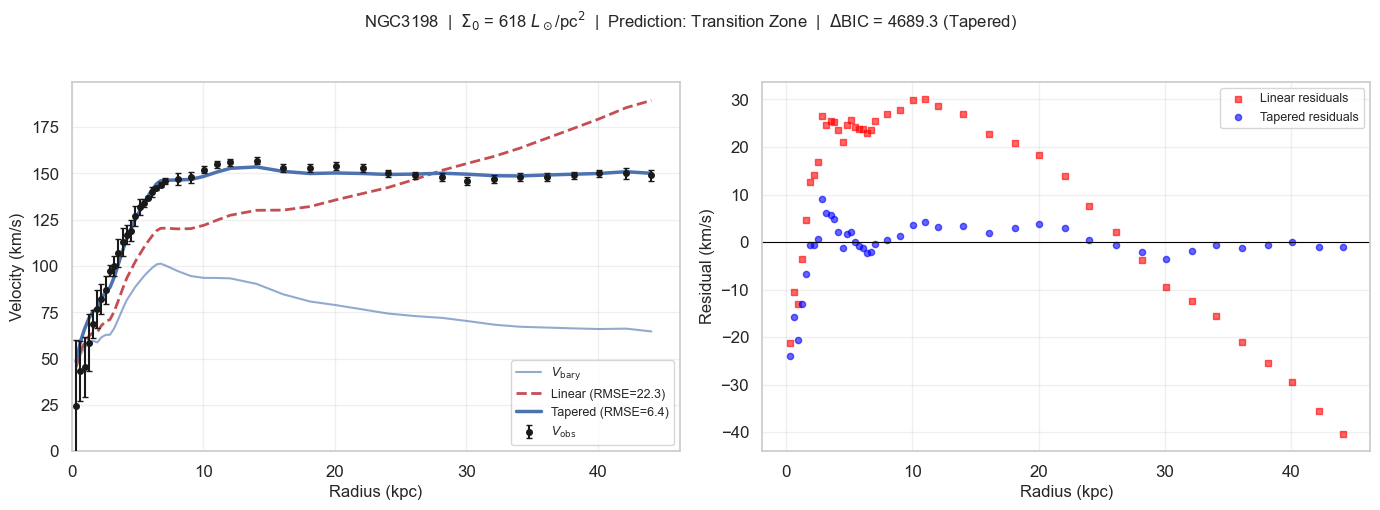

2026-02-15 07:57:47 | INFO     | src.physics | DDO161: omega=2.9977 +/- 0.0280 km/s/kpc  chi2_r=3.17  RMSE=2.28 km/s



Processing: DDO161
  Sigma_0 = 58.6 Lsun/pc^2
  Prediction: Tapered (LSB Regime)
  Linear:  omega=2.998, RMSE=2.28, BIC=98.4
  Tapered: omega=4.746, R_t=18.76, RMSE=1.64, BIC=20.1
  Delta BIC = 78.4 -> Preferred: Tapered
  Verdict: CORRECT


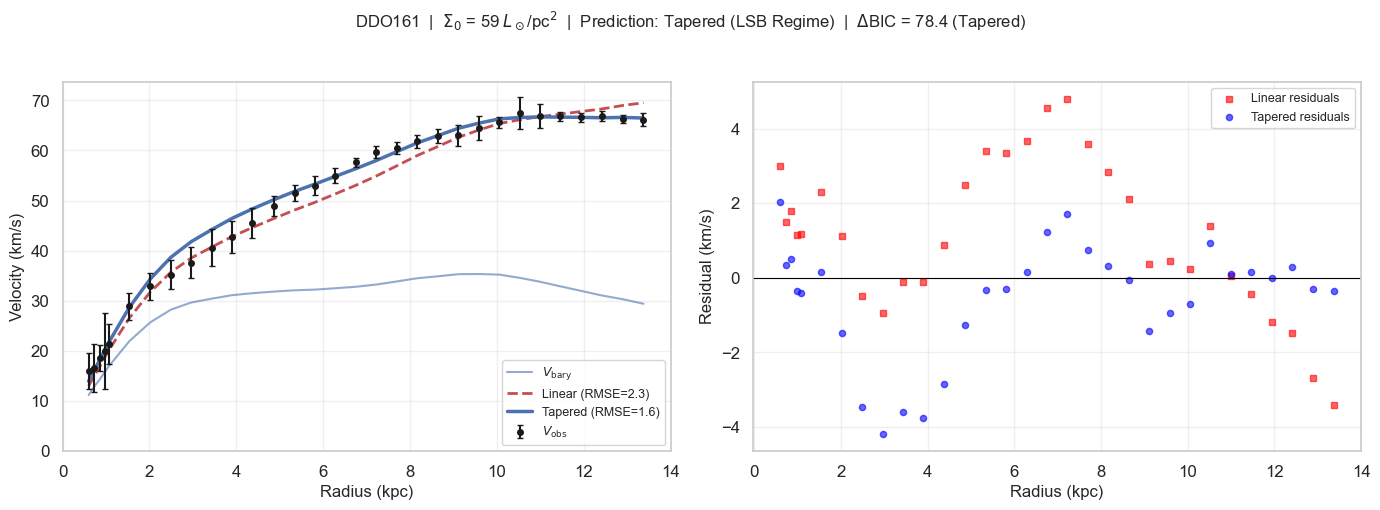

2026-02-15 07:57:48 | INFO     | src.physics | NGC2841: omega=3.7676 +/- 0.0205 km/s/kpc  chi2_r=69.15  RMSE=57.51 km/s



Processing: NGC2841
  Sigma_0 = 2259.7 Lsun/pc^2
  Prediction: Linear (HSB Regime)
  Linear:  omega=3.768, RMSE=57.51, BIC=3392.2
  Tapered: omega=29.801, R_t=6.02, RMSE=7.59, BIC=117.0
  Delta BIC = 3275.2 -> Preferred: Tapered
  Verdict: INCORRECT


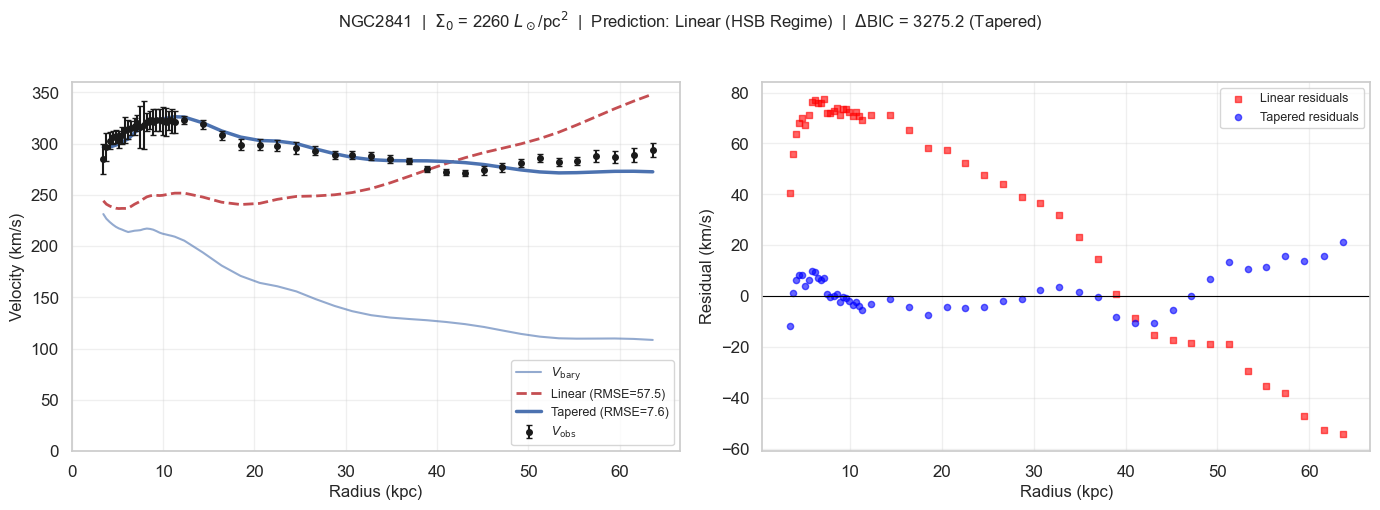

2026-02-15 07:57:48 | INFO     | src.physics | NGC7331: omega=2.7636 +/- 0.0301 km/s/kpc  chi2_r=7.68  RMSE=16.58 km/s



Processing: NGC7331
  Sigma_0 = 1582.9 Lsun/pc^2
  Prediction: Linear (HSB Regime)
  Linear:  omega=2.764, RMSE=16.58, BIC=272.5
  Tapered: omega=3.138, R_t=181.55, RMSE=17.61, BIC=324.3
  Delta BIC = -51.8 -> Preferred: Linear
  Verdict: CORRECT


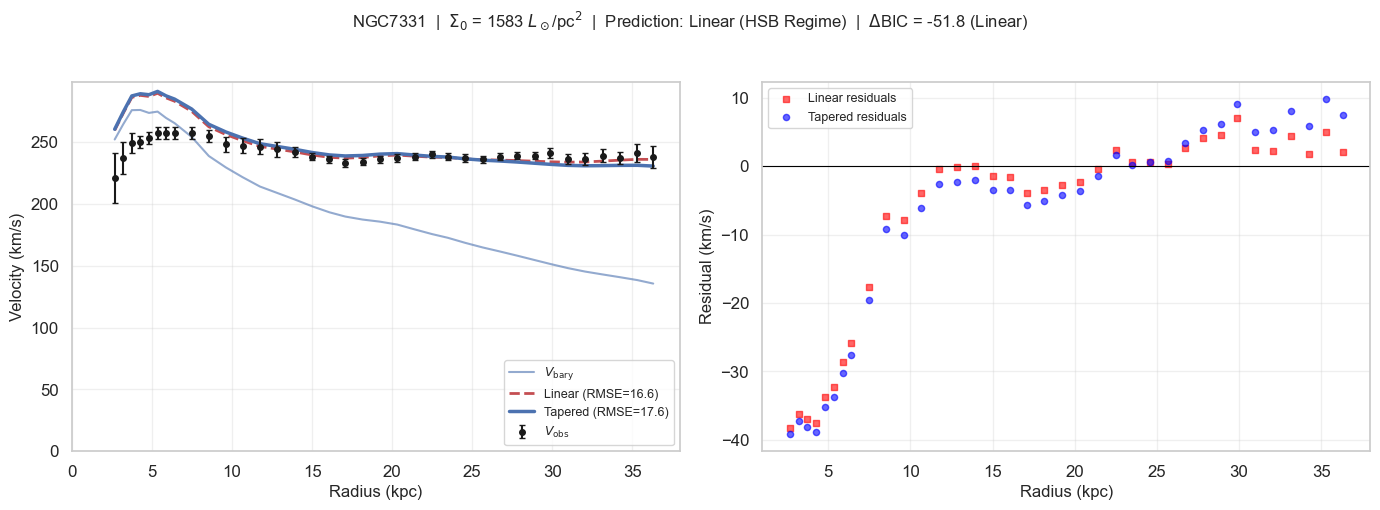

2026-02-15 07:57:49 | INFO     | src.physics | NGC0300: omega=6.3084 +/- 0.1018 km/s/kpc  chi2_r=8.11  RMSE=11.14 km/s



Processing: NGC0300
  Sigma_0 = 151.9 Lsun/pc^2
  Prediction: Tapered (LSB Regime)
  Linear:  omega=6.308, RMSE=11.14, BIC=197.8
  Tapered: omega=17.981, R_t=4.76, RMSE=3.53, BIC=17.8
  Delta BIC = 180.0 -> Preferred: Tapered
  Verdict: CORRECT


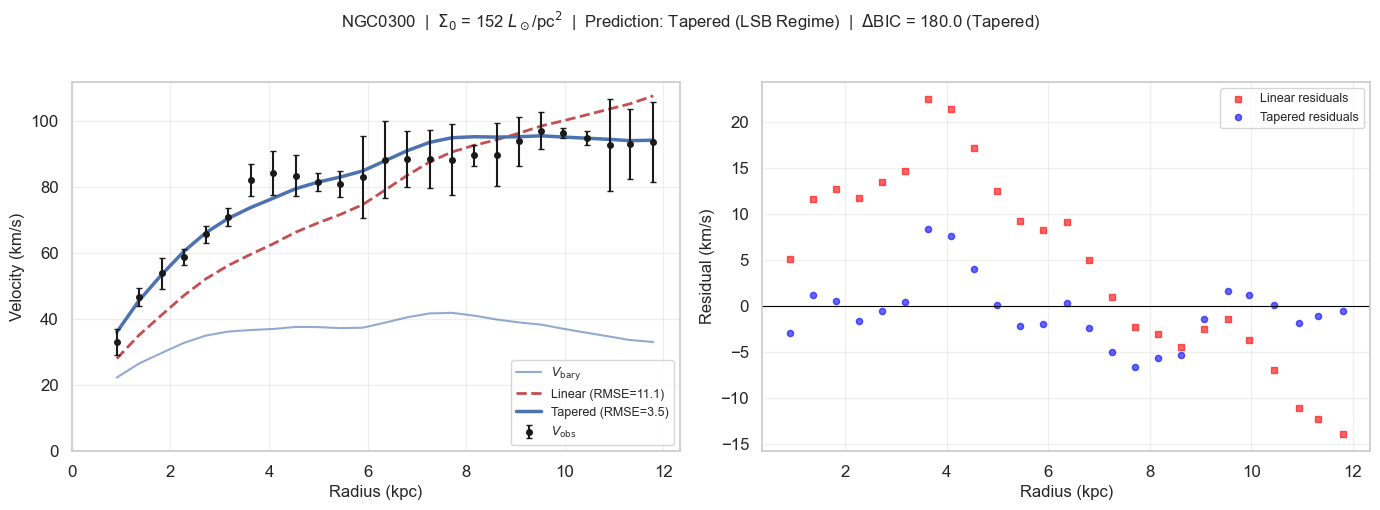

2026-02-15 07:57:49 | INFO     | src.physics | M33: omega=6.9749 +/- 0.0418 km/s/kpc  chi2_r=72.91  RMSE=31.05 km/s



Processing: M33
  Sigma_0 = nan Lsun/pc^2
  Prediction: Unknown
  Linear:  omega=6.975, RMSE=31.05, BIC=4159.8
  Tapered: omega=42.975, R_t=1.98, RMSE=9.49, BIC=264.2
  Delta BIC = 3895.5 -> Preferred: Tapered
  Verdict: N/A (Transition)


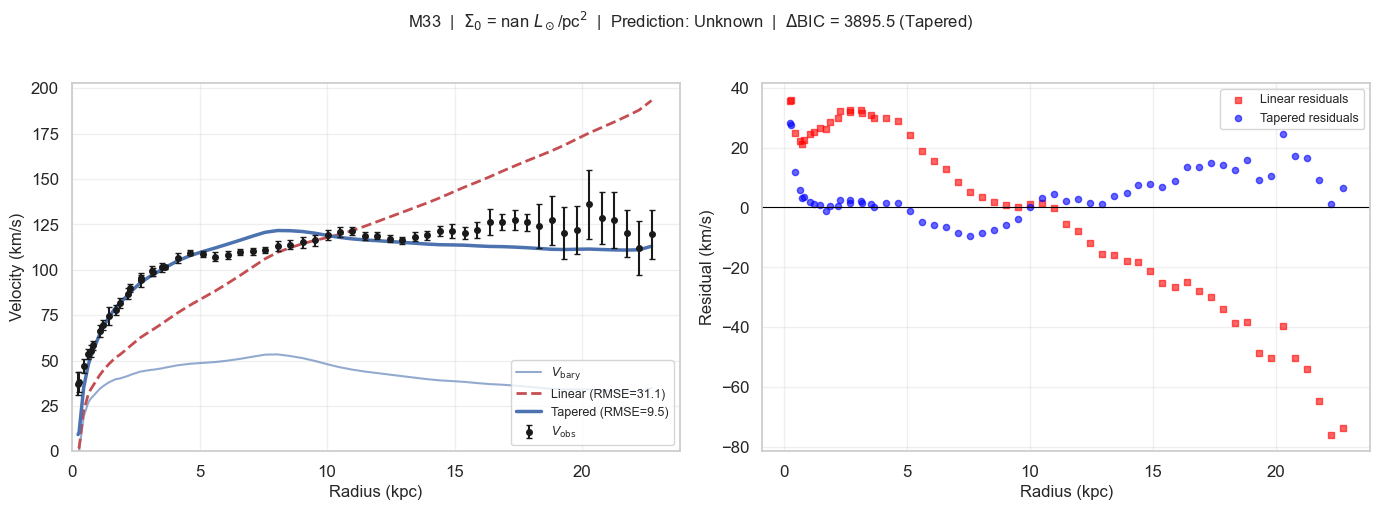


Gallery complete: 7 galaxies processed.


In [5]:
gallery_results = []

for gid in available:
    print(f'\n{"=" * 60}')
    print(f'Processing: {gid}')
    print(f'{"=" * 60}')

    # --- Fetch data ---
    df = query_profiles_as_dataframe(session, gid)
    radius = df['radius_kpc'].values
    v_obs = df['v_obs'].values
    v_err = df['v_err'].values
    v_gas = df['v_gas'].values
    v_disk = df['v_disk'].values
    v_bulge = df['v_bulge'].values

    v_bary = compute_v_bary(
        v_gas, v_disk, v_bulge,
        upsilon_disk=UPSILON_DISK,
        upsilon_bulge=UPSILON_BULGE,
    )

    # --- Prediction ---
    if gid in meta_lookup.index:
        lum = float(meta_lookup.loc[gid, 'luminosity_band_36'])
        r_d = float(meta_lookup.loc[gid, 'r_disk_kpc'])
        sigma_0, prediction, k_range = predict_regime(gid, lum, r_d)
    else:
        sigma_0, prediction, k_range = np.nan, 'Unknown', 'N/A'

    # --- Fit A: Flynn 2025 Linear ---
    linear_fit = fit_omega(
        radius, v_obs, v_err, v_bary,
        galaxy_id=gid,
        method_version='v3_gallery_linear',
        upsilon_disk=UPSILON_DISK,
        upsilon_bulge=UPSILON_BULGE,
    )

    # --- Fit B: Schneider 2026 Tapered (robust) ---
    tapered_fit = fit_omega_tapered_robust(
        radius, v_obs, v_err, v_bary,
        galaxy_id=gid,
        method_version='v3_gallery_tapered',
        upsilon_disk=UPSILON_DISK,
        upsilon_bulge=UPSILON_BULGE,
    )

    # --- Compute BIC ---
    bic_linear = compute_bic(linear_fit.n_points, 1, linear_fit.chi_squared)
    bic_tapered = compute_bic(tapered_fit.n_points, 2, tapered_fit.chi_squared)
    delta_bic = bic_linear - bic_tapered  # positive = Tapered preferred

    # Determine preferred model from BIC
    if abs(delta_bic) < 2:
        preferred = 'Indistinguishable'
    elif delta_bic > 0:
        preferred = 'Tapered'
    else:
        preferred = 'Linear'

    # Check if prediction matches outcome
    if prediction.startswith('Tapered'):
        verdict = 'CORRECT' if preferred == 'Tapered' else 'INCORRECT'
    elif prediction.startswith('Linear'):
        verdict = 'CORRECT' if preferred in ('Linear', 'Indistinguishable') else 'INCORRECT'
    else:
        verdict = 'N/A (Transition)'

    gallery_results.append({
        'GalaxyID': gid,
        'Sigma_0': sigma_0,
        'Prediction': prediction,
        'Linear_RMSE': linear_fit.residuals_rmse,
        'Tapered_RMSE': tapered_fit.residuals_rmse,
        'Linear_BIC': bic_linear,
        'Tapered_BIC': bic_tapered,
        'Delta_BIC': delta_bic,
        'Preferred_Model': preferred,
        'Verdict': verdict,
    })

    # --- Print summary ---
    print(f'  Sigma_0 = {sigma_0:.1f} Lsun/pc^2')
    print(f'  Prediction: {prediction}')
    print(f'  Linear:  omega={linear_fit.omega_value:.3f}, '
          f'RMSE={linear_fit.residuals_rmse:.2f}, BIC={bic_linear:.1f}')
    if tapered_fit.converged:
        print(f'  Tapered: omega={tapered_fit.omega_value:.3f}, '
              f'R_t={tapered_fit.rt_value:.2f}, '
              f'RMSE={tapered_fit.residuals_rmse:.2f}, BIC={bic_tapered:.1f}')
    else:
        print(f'  Tapered: DID NOT CONVERGE')
    print(f'  Delta BIC = {delta_bic:.1f} -> Preferred: {preferred}')
    print(f'  Verdict: {verdict}')

    # === VISUALIZATION: 2-panel plot ===
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # --- Left panel: Rotation Curve ---
    ax = axes[0]
    ax.errorbar(
        radius, v_obs, yerr=v_err,
        fmt='ko', markersize=4, capsize=2, label=r'$V_{\mathrm{obs}}$', zorder=3,
    )
    ax.plot(radius, v_bary, 'b-', linewidth=1.5, alpha=0.6,
            label=r'$V_{\mathrm{bary}}$')
    ax.plot(radius, linear_fit.v_model, 'r--', linewidth=2,
            label=f'Linear (RMSE={linear_fit.residuals_rmse:.1f})')
    if tapered_fit.converged:
        ax.plot(radius, tapered_fit.v_model, 'b-', linewidth=2.5,
                label=f'Tapered (RMSE={tapered_fit.residuals_rmse:.1f})')

    ax.set_xlabel('Radius (kpc)', fontsize=12)
    ax.set_ylabel('Velocity (km/s)', fontsize=12)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.legend(fontsize=9, loc='lower right')
    ax.grid(True, alpha=0.3)

    # --- Right panel: Residuals ---
    ax = axes[1]
    ax.axhline(0, color='black', linewidth=0.8)
    ax.scatter(radius, linear_fit.residuals, c='red', s=20, alpha=0.6,
               marker='s', label='Linear residuals')
    if tapered_fit.converged:
        ax.scatter(radius, tapered_fit.residuals, c='blue', s=20, alpha=0.6,
                   marker='o', label='Tapered residuals')

    ax.set_xlabel('Radius (kpc)', fontsize=12)
    ax.set_ylabel('Residual (km/s)', fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # Suptitle with prediction vs outcome
    verdict_color = (
        'green' if verdict == 'CORRECT'
        else 'red' if verdict == 'INCORRECT'
        else 'orange'
    )
    fig.suptitle(
        f'{gid}  |  $\\Sigma_0$ = {sigma_0:.0f} $L_\\odot$/pc$^2$  |  '
        f'Prediction: {prediction}  |  '
        f'$\\Delta$BIC = {delta_bic:.1f} ({preferred})',
        fontsize=12, y=1.02,
    )

    plt.tight_layout()
    fig.savefig(
        FIGURES_DIR / f'gallery_{gid}.png',
        dpi=150, bbox_inches='tight',
    )
    plt.show()

session.close()
print(f'\nGallery complete: {len(gallery_results)} galaxies processed.')

## 5. The Verification Table

Summary dataframe validating whether the $\Sigma_0$-based prediction
correctly identified the preferred model for each galaxy.

In [6]:
gallery_df = pd.DataFrame(gallery_results)

# Format for display
display_df = gallery_df.copy()
display_df['Sigma_0'] = display_df['Sigma_0'].map(lambda x: f'{x:.1f}' if pd.notna(x) else 'N/A')
for col in ['Linear_RMSE', 'Tapered_RMSE']:
    display_df[col] = display_df[col].map(lambda x: f'{x:.2f}')
for col in ['Linear_BIC', 'Tapered_BIC', 'Delta_BIC']:
    display_df[col] = display_df[col].map(lambda x: f'{x:.1f}')

print('Model Gallery Validation Table')
print('=' * 80)
display(display_df)

# Score
testable = gallery_df[gallery_df['Verdict'].isin(['CORRECT', 'INCORRECT'])]
n_correct = (testable['Verdict'] == 'CORRECT').sum()
n_total = len(testable)
print(f'\nPrediction Accuracy: {n_correct}/{n_total}'
      f' ({n_correct/n_total*100:.0f}%)' if n_total > 0 else '')

# Export
out_path = TABLES_DIR / 'model_gallery_validation.csv'
gallery_df.to_csv(out_path, index=False, float_format='%.6f')
print(f'Saved: {out_path}')

Model Gallery Validation Table


,GalaxyID,Sigma_0,Prediction,Linear_RMSE,Tapered_RMSE,Linear_BIC,Tapered_BIC,Delta_BIC,Preferred_Model,Verdict
0,DDO154,61.6,Tapered (LSB Regime),5.46,1.51,947.0,38.8,908.2,Tapered,CORRECT
1,NGC3198,617.9,Transition Zone,22.34,6.44,4752.7,63.4,4689.3,Tapered,N/A (Transition)
2,DDO161,58.6,Tapered (LSB Regime),2.28,1.64,98.4,20.1,78.4,Tapered,CORRECT
3,NGC2841,2259.7,Linear (HSB Regime),57.51,7.59,3392.2,117.0,3275.2,Tapered,INCORRECT
4,NGC7331,1582.9,Linear (HSB Regime),16.58,17.61,272.5,324.3,-51.8,Linear,CORRECT
5,NGC0300,151.9,Tapered (LSB Regime),11.14,3.53,197.8,17.8,180.0,Tapered,CORRECT
6,M33,N/A,Unknown,31.05,9.49,4159.8,264.2,3895.5,Tapered,N/A (Transition)



Prediction Accuracy: 4/5 (80%)
Saved: C:\Projects\ISM\baryonic-omega-analysis\results\tables\model_gallery_validation.csv


## 6. Summary & Session Log

In [7]:
log = setup_logger(
    'nb06_model_gallery',
    log_file=True,
    clear_logs=True,
)

log.info('=' * 60)
log.info('NOTEBOOK 06 -- MODEL GALLERY: LINEAR vs TAPERED')
log.info('=' * 60)
log.info('Flynn 2025 (Linear): V_bary + omega*R')
log.info('Schneider 2026 (Tapered): V_bary + omega*R / (1 + R/R_t)')
log.info('Upsilon_disk=%.2f, Upsilon_bulge=%.2f', UPSILON_DISK, UPSILON_BULGE)
log.info('---')
log.info('GALLERY SAMPLE: %d galaxies', len(gallery_df))
for _, row in gallery_df.iterrows():
    log.info(
        '  %s: Sigma_0=%.1f, Prediction=%s, Preferred=%s, '
        'Delta_BIC=%.1f, Verdict=%s',
        row['GalaxyID'], row['Sigma_0'], row['Prediction'],
        row['Preferred_Model'], row['Delta_BIC'], row['Verdict'],
    )
log.info('---')
testable = gallery_df[gallery_df['Verdict'].isin(['CORRECT', 'INCORRECT'])]
if len(testable) > 0:
    n_correct = (testable['Verdict'] == 'CORRECT').sum()
    log.info('PREDICTION ACCURACY: %d/%d (%.0f%%)',
             n_correct, len(testable), n_correct/len(testable)*100)
log.info('---')
log.info('OUTPUTS:')
log.info('  Table: model_gallery_validation.csv')
log.info('  Figures: gallery_*.png (one per galaxy)')
log.info('=' * 60)

print('\nLog written to logs/nb06_model_gallery.log')

2026-02-15 07:57:49 | INFO     | nb06_model_gallery | ============================================================
2026-02-15 07:57:49 | INFO     | nb06_model_gallery | NOTEBOOK 06 -- MODEL GALLERY: LINEAR vs TAPERED
2026-02-15 07:57:49 | INFO     | nb06_model_gallery | ============================================================
2026-02-15 07:57:49 | INFO     | nb06_model_gallery | Flynn 2025 (Linear): V_bary + omega*R
2026-02-15 07:57:49 | INFO     | nb06_model_gallery | Schneider 2026 (Tapered): V_bary + omega*R / (1 + R/R_t)
2026-02-15 07:57:49 | INFO     | nb06_model_gallery | Upsilon_disk=0.50, Upsilon_bulge=0.70
2026-02-15 07:57:49 | INFO     | nb06_model_gallery | ---
2026-02-15 07:57:49 | INFO     | nb06_model_gallery | GALLERY SAMPLE: 7 galaxies
2026-02-15 07:57:49 | INFO     | nb06_model_gallery |   DDO154: Sigma_0=61.6, Prediction=Tapered (LSB Regime), Preferred=Tapered, Delta_BIC=908.2, Verdict=CORRECT
2026-02-15 07:57:49 | INFO     | nb06_model_gallery |   NGC3198: Sigma_


Log written to logs/nb06_model_gallery.log


## Conclusions

### Questions to Evaluate

1. **Do LSB galaxies prefer the Tapered model?** Examine the $\Delta$BIC values
   for galaxies with low $\Sigma_0$. If the Linear model overshoots at large radii
   (visible in the residual plots), this supports the saturation mechanism.

2. **Do HSB galaxies prefer the Linear model?** For high-$\Sigma_0$ galaxies,
   check whether the extra $R_t$ parameter is justified by BIC, or whether the
   simpler Linear form is sufficient.

3. **Does the $\Sigma_0$ predictor work?** The verification table scores each
   prediction against the BIC outcome. Examine the accuracy and identify any
   galaxies where the prediction fails — these may warrant closer investigation.

### Interpretation Guide

- **Interior Solution** (Tapered): The $\omega$ correction transitions from
  linear growth to saturation at $R_t$. If $R_t \sim k \cdot R_d$, the taper
  scale is set by the baryonic disk.

- **Boundary Solution** (Linear): If $R_t$ exceeds the observed data extent,
  the correction is effectively linear throughout, and the extra parameter
  adds no information.

- **$\Delta$BIC scale** (Kass & Raftery 1995): $|\Delta\text{BIC}| < 2$ is
  inconclusive; $2$–$6$ is positive evidence; $6$–$10$ is strong; $>10$ is
  very strong.

### Next Steps

- **Phase III:** Apply the model-selection framework to the full SPARC
  catalog using $\Sigma_0$ to auto-select the appropriate model per galaxy.
- **Cosmic Dipole:** Re-test the dipole alignment with model-optimized
  $\omega$ values.